# import librairies

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, cho_solve
from numpy.linalg import norm
from scipy.stats import beta
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
import timeit
import scipy.io as sio
import scipy.integrate as integrate
from sklearn import manifold
from sklearn.utils.validation import column_or_1d

/home/nash/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:53: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


# define eigenvalues: $\lambda_j$ and eigenfunctions: $\phi_j(x)$ of the Matérn operator

In [2]:
eps0=1 # shape parameter
s0= 1.2 # smoothness parameter

# the eigenvalue: \lambda_j
def eigenv_matern(j, epsilon_M = eps0 , s=s0):
    lambda_j = 1/(epsilon_M + (j*math.pi)**2)**s
    return lambda_j
    
# the values of eigenfunction evaluated at x: \phi_j(x)    
def eigenf_matern(j, x):
    return np.sqrt(2)*np.sin(j*math.pi*x)

# construct the vector of eigenfunctions: $(\phi_1(x),..,\phi_n(x))$ and the matrix of eigenvalues: $diag([\lambda_1,...,\lambda_n])$

In [3]:
# a vector with j-th component is: eigenf_matern(j,x)
def Phi_Matern(x, NT):
    Phi = []
    for j in range(0,NT):
        Phi.append(eigenf_matern(j+1, x))
    return np.asarray(Phi).T

# a diagonal matrix with j-th component is: eigenv_matern(j)
def Lambda_Matern(NT):
    Lambda = np.zeros(NT)
    for j in range(0,NT):
        Lambda[j] = eigenv_matern(j+1) 
    return np.diag(Lambda)

# evaluate the truncated GP: $f_n(x) = \sum_{j=1}^{n}a_j\phi_j(x)$

In [4]:
def EVAL_function_M(A,x):
    A = np.asarray(A)
    dim = A.shape
    if len(dim) == 1:
        NT = len(A)
    else:
        if len(dim) == 2:
            NT = dim[1]
        else:
            raise ValueError('A very specific bad thing happened.')

    Phi = Phi_Matern(x, NT)
    return np.matmul(Phi,A.T).T 

# construct the matrix of eigenvalues: $diag([1/\lambda_1,...,1/\lambda_n])$

In [5]:
def Inv_Lambda_Matern(NT ):
    Lambda = np.zeros(NT)
    for j in range(0, NT):
        Lambda[j] = 1/eigenv_matern(j+1)
    return np.diag(Lambda)

# evaluate the posterior distribution of $A=(a_1,...,a_n)^T$

In [6]:
sigma = 10**(-2) # noise std

def Mean_Covariance_Matern(x, y, NT, sigma = sigma ):
    """
    Input:
    x,y: Data
    NT: number of truncation
    sigma: noise std
    Output:
    mu: mean
    Sigma: covariance
    """
    inv_Lambda = Inv_Lambda_Matern(NT)
    Phi = Phi_Matern(x,NT)
    inv_Covariance = 1/sigma**2*np.matmul(Phi.T,Phi) + inv_Lambda
    Covariance = np.linalg.inv(inv_Covariance)
    temp1 = np.matmul(Phi.T, y)
    Mean = 1/sigma**2*np.matmul(Covariance, temp1)  
    return Mean, inv_Covariance 

# evaluate the potential at $A$: $U(A)$ and its gradient: $\nabla U(A)$

In [7]:
def Potential_Matern(A,x,y):
    NT = len(A)
    mu,   S_inv = Mean_Covariance_Matern(x, y, NT) 
    temp = A.flatten() - mu.flatten()
    Potential = np.matmul(np.matmul(temp,S_inv),temp)/2
    return -Potential

def Potential_Der_Matern(A,x,y):
    NT = len(A)
    mu,  S_inv = Mean_Covariance_Matern(x, y, NT) 
    return -np.matmul(A.flatten()-mu.flatten(),S_inv).flatten() 

# spherical HMC sampling as a one leap-frop with L iterations

In [8]:
def SphHMC(Potential, Potential_Derivative, A_cur,  x, y, L , eps ):
    A = A_cur
    NT = len(A_cur)
    v_r = np.random.normal(size=(NT,)) 
    v = v_r - np.inner(A, v_r)*A  
    Samp = []
    U_0 = Potential(A, x,y)
    du   = Potential_Derivative(A, x,y)
    i =0
    H_1 = U_0 - sum(v**2)/2
    L = 1 + int(np.ceil(np.random.uniform(0,L)))
    while   i < L :
        Samp.append(A)
        du  = Potential_Derivative(A , x,y)
        du = du - np.inner(A,du)*A
        v = v + eps/2*du
        A0 = A.flatten()
        v_norm = norm(v )
        cosvt = math.cos(v_norm*eps)
        sinvt = math.sin(v_norm*eps)
        A = A0*cosvt + v/v_norm*sinvt  
        v = (-A0*sinvt*v_norm + v*cosvt)
        du = Potential_Derivative(A, x,y)
        du = du - np.inner(A,du)*A
        v = v + eps/2*du 
        U_i = Potential(A,x,y  )
        i +=1    
    H_L = U_i - sum(v**2)/2
    if math.log(np.random.rand()) < -H_L+H_1:
        return A, 1, U_i, du
    else:
        return A_cur, 0, U_i, du

# generate an example of PDF and find its square-root (SRDF)

In [9]:
def sin_10(x):
    return abs((1-x)*(1 + np.sin(-math.pi/2 + 2*math.pi*x*5)))

def True_function(x):
    #return SRDF of beta distribution with params beta1, beta2
    I = integrate.quad(lambda t: sin_10(t), 0,1)[0]
    return  np.sqrt(sin_10(x)/I)     

# display the generated PDF and SRDF

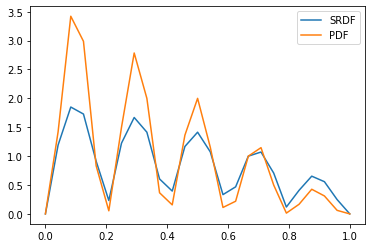

In [10]:
x_obs = np.linspace(0, 1, num=25 , endpoint=True)
plt.plot(x_obs, True_function(x_obs),label='SRDF')
plt.plot(x_obs, True_function(x_obs)**2,label='PDF')
plt.legend(loc='upper right' )
plt.show()

# generate random coefficients with unit norm

In [11]:
def generate_norm_1(NT):
    q = np.random.normal(size=(NT))
    return q/norm(q)

# run the general MCMC sampling with NSamp leap-frog

In [12]:
NSamp = 10000
NBurnIn =  100

x_obs = np.linspace(0, 1, num=25 , endpoint=True)    
x_comp = np.linspace(0, 1, num=500, endpoint=True)
y_obs = True_function(x_obs)

TF = True_function(x_comp)**2
NT =30
Samp = []
acpt = 0
accp = 0
a_0  = generate_norm_1(NT)
S = a_0
P =[]

start = timeit.default_timer()

for Iter in range(NSamp):

    if(Iter%100==0 and Iter >0):

        print(f'\r Acceptance rate between {Iter-100+1} and {Iter}: ', accp/100,'... ', end='', flush=True)
        accp=0

    S, ind, Potentials, DPotentials = SphHMC(Potential_Matern, Potential_Der_Matern,S, x_obs, y_obs, 23 , .0001 )
    accp = accp + ind

    if (Iter>NBurnIn):
        Samp.append(S)
        acpt = acpt +  ind
        P.append(Potentials)
  

end = timeit.default_timer()
print('executed time:', end-start)

 Acceptance rate between 801 and 900:  0.04 ... executed time: 49.77557967800021


# show the trajectory of some coefficients with MCMC

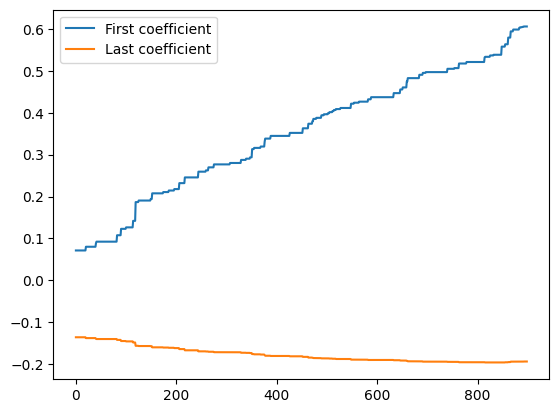

In [13]:
Samp_sq = np.asarray(Samp) 

plt.style.use('default')
plt.plot(Samp_sq.T[0], label = 'First coefficient')
plt.plot(Samp_sq.T[-1], label = 'Last coefficient')
plt.legend(loc='upper left' )
plt.show()

# construct the confidence interval of mean: Mean_ap, lower bound: Lower, upper bound: Upper

In [14]:
def Mean_Interval_confidence(A,x):
    F_ap  = EVAL_function_M(A, x)**2 
    Mean_ap  = np.mean(F_ap , axis =0)
    std_deviation = np.std(F_ap , axis=0)
    Lower = Mean_ap - 2*std_deviation
    Upper= Mean_ap + 2*std_deviation
    return Mean_ap, Lower, Upper

# intrepret the results of MCMC sampling

In [15]:
print('Global acceptance rate :',acpt/(NSamp-NBurnIn))
M, L, U = Mean_Interval_confidence(Samp, x_comp)

Global acceptance rate : 0.08222222222222222


# evaluate some criteria between true and approximated PDF

In [16]:
#ISE
Diff = (TF - M)**2
a = 1/len(Diff)
ISE_i = np.trapz(Diff,dx=a)
print('the integrated squared error is:',ISE_i)

#GEODESIC    
inner = np.sqrt(M*TF)/np.sqrt(np.trapz(M,dx=1/len(M)))/np.sqrt(np.trapz(TF,dx=1/len(TF)))
b= 1/len(inner)
FRao = math.acos(np.trapz(inner,dx=b)) 
print('the geodesic distance is:',FRao)

the integrated squared error is: 3.0338591061972147
the geodesic distance is: 0.7996297447940258


# display the true and approximated PDF 

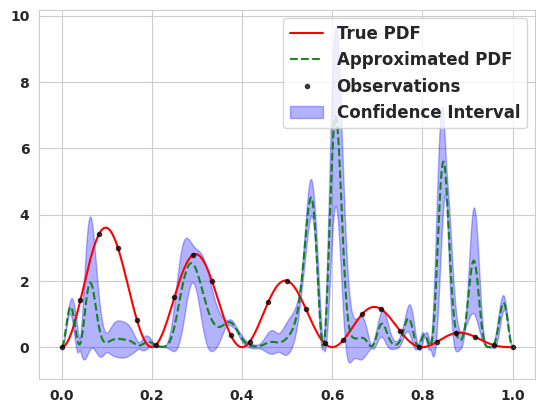

In [17]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams['font.weight'] = 'bold'
x_val = x_comp
plt.plot(x_val, True_function(x_comp )**2 , 'red', label = 'True PDF', alpha = 1)
plt.plot(x_val, M, 'g--', label ='Approximated PDF' , alpha = .9 )
plt.fill_between(x_val, L, U, color='blue', label = 'Confidence Interval', alpha=0.3)
plt.plot(x_obs, y_obs**2,  ' k.', label ='Observations', alpha = .7)
plt.legend(loc='upper right' )
plt.show()